## ASTR 375 Final Project Dataset Creator 
### Isaac Moskowitz
### Professor Malena Rice, TF Konstantin Gerbig

This jupyter-notebook guides you through the creation of synthetic exomoon transit curves. These curves will represent a wide variety of different star-planet-moon systems, with a great diversity of stellar/planetary mass ratios, moon/planet mass ratios, planetary semi-major axis, and moon orbital semi-major axis. These lightcurves will train the LSTM model on what it may expect to find in real datasets as well as establish limits in parameter space that determine which sytems are most likely to be detected using this method.

In [1]:
!pwd

/Users/moskowitzi/Desktop/Senior_Year_at_Yale/ASTR-375-Final-Project/datasets


In [5]:
import numpy as np
import pandas as pd
import matplotlib as plt
import sys
import os
os.chdir("/Users/moskowitzi/Desktop/Senior_Year_at_Yale/ASTR-375-Final-Project/")
sys.path.append("/Users/moskowitzi/Desktop/Senior_Year_at_Yale/ASTR-375-Final-Project/MoonPy")
from moonpy import *
#from moonpy import LightCurve
import batman
from batman import TransitParams
from batman import TransitModel

from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
from tqdm import tqdm
#from moonpy import transitmodel as tm 

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 10, 
                     'ytick.labelsize': 10,
                     'axes.labelsize': 12,
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6)
                    })


In [6]:
#ticid = 261105201
#starName = f"TIC {ticid}"
starName = "AU Mic"

# Query the TIC catalog for RA and Dec
from astroquery.vizier import Vizier
result = Vizier.query_object(starName, catalog="IV/38/tic")
ra = result[0]['RAJ2000'][0]
dec = result[0]['DEJ2000'][0]

print(f"Coordinates: RA={ra}, Dec={dec}")

coord = SkyCoord(ra, dec, unit = "deg")
sectorTable = Tesscut.get_sectors(coordinates=f"{ra} {dec}")
print(sectorTable)

obsTable = Observations.query_criteria(
    objectname=starName,
    obs_collection="TESS",
    dataproduct_type="timeseries",
    project="TESS"
)

print(f"Found {len(obsTable)} light curves")
data_products = Observations.get_product_list(obsTable[0])
object_manifest = Observations.download_products(data_products, productSubGroupDescription='LC') # to download the lightcurve
lightcurve_files = [f for f in object_manifest['Local Path'] if f.endswith('.fits')]
print(len(lightcurve_files))

Coordinates: RA=311.28608498301, Dec=-31.37181471254


  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0001-1-4      1      1   4
tess-s0027-1-3     27      1   3
Found 5 light curves
INFO: Found cached file ./mastDownload/TESS/tess2020186164531-s0027-0000000441418475-0189-s/tess2020186164531-s0027-0000000441418475-0189-s_lc.fits with expected size 1785600. [astroquery.query]
1


XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  100 / length of first array dimension                NAXIS2  =                17546 / length of second array dimension               PCOUNT  =                    0 / group parameter count (not used)               GCOUNT  =                    1 / group count (not used)                         TFIELDS =                   20 / number of table fields                         TTYPE1  = 'TIME    '           / column title: data time stamps                 TFORM1  = 'D       '           / column format: 64-bit floating point           TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS JulianTDISP1  = 'D14.7   '           / column display format                          TTYPE2  = 'TIMECORR'           / column 

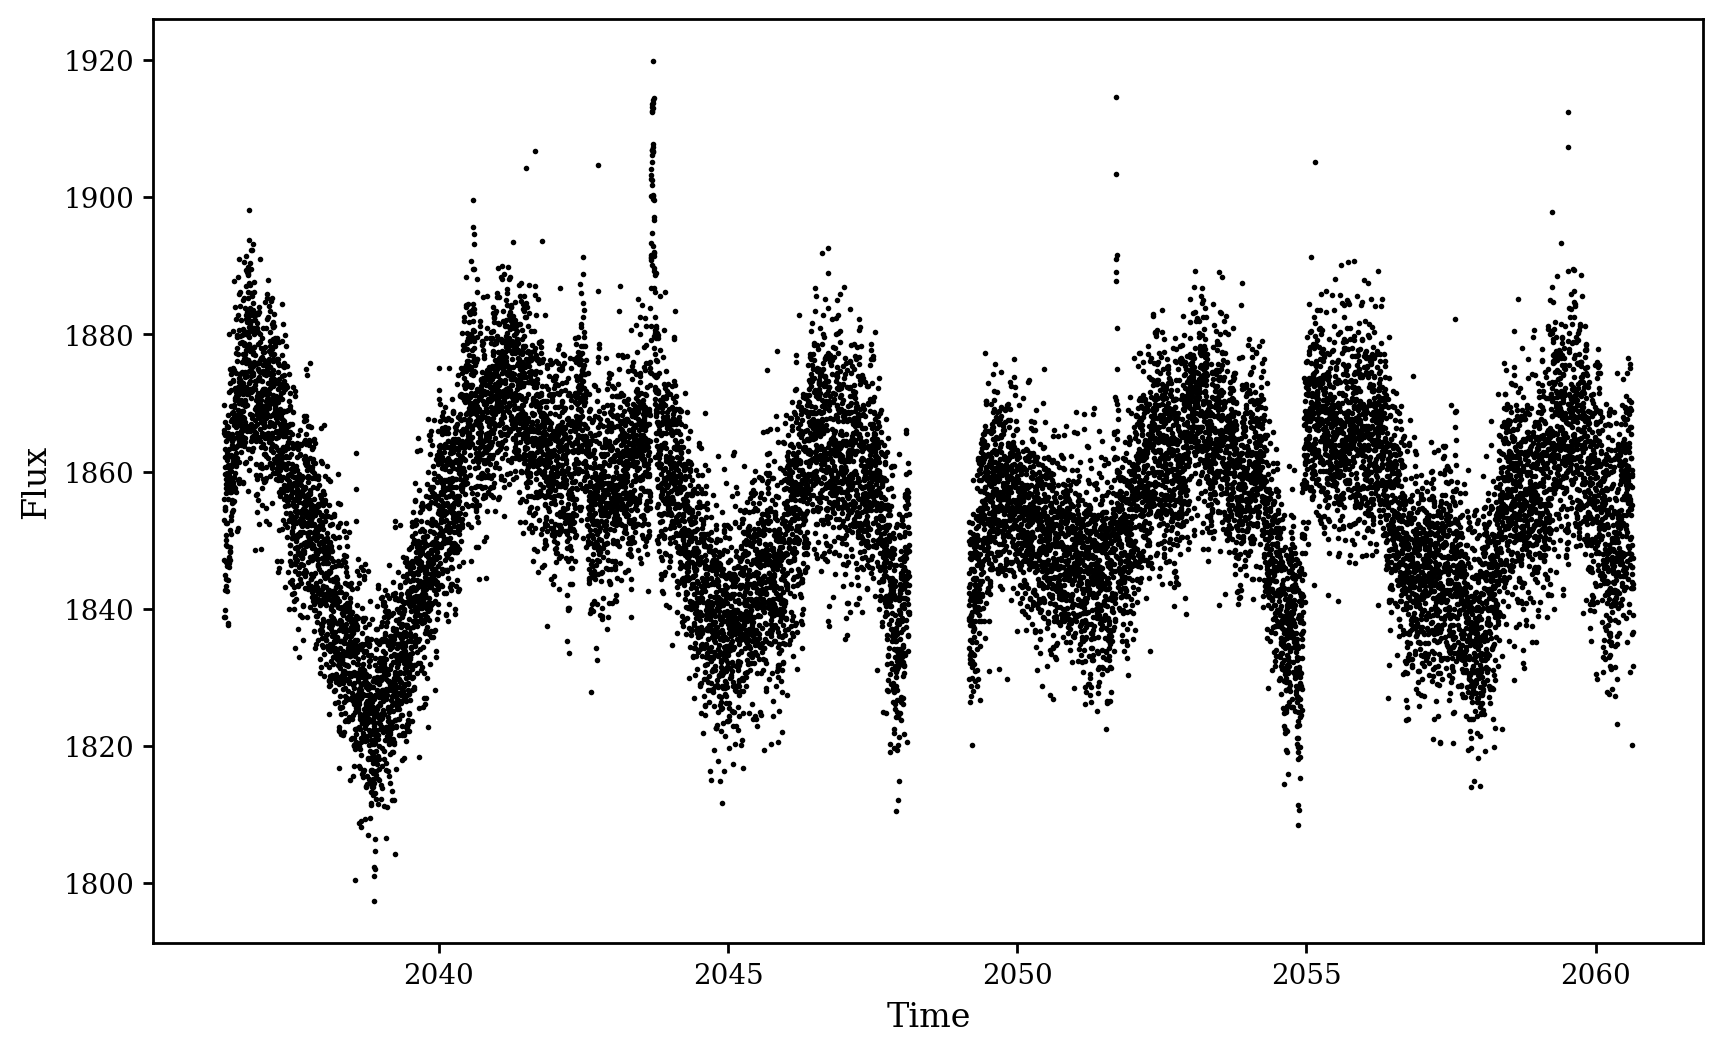

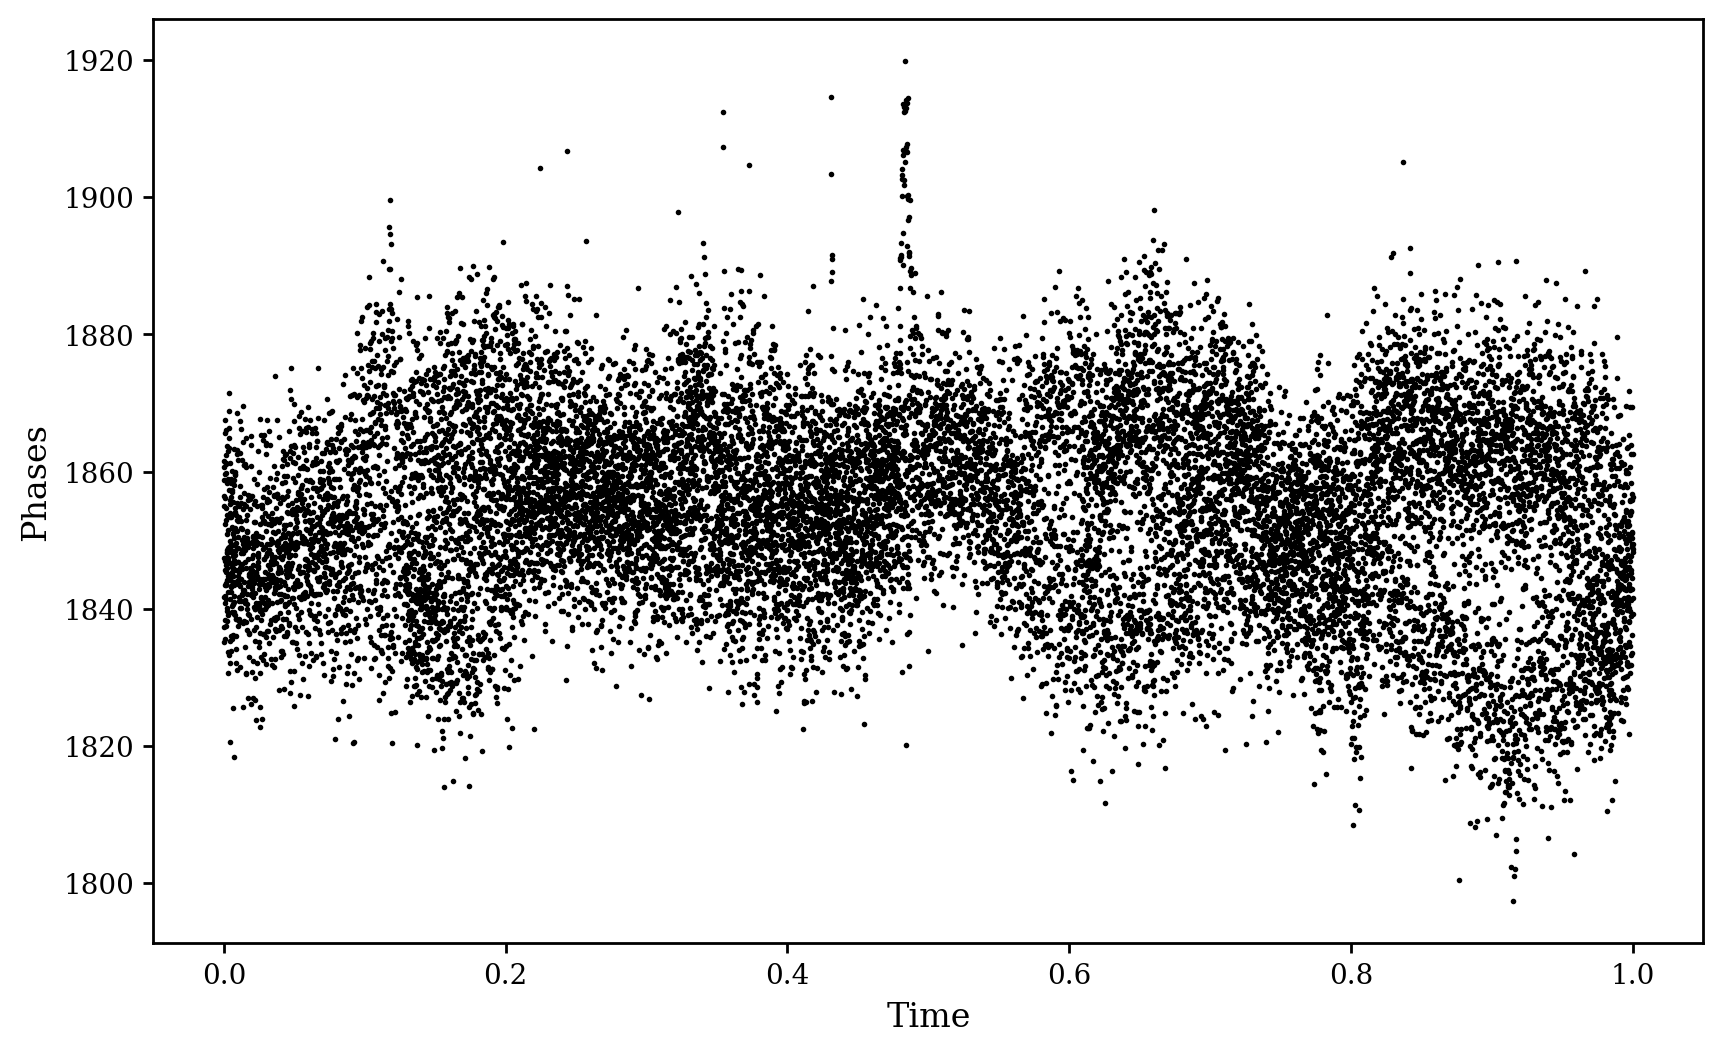

original MoonpyLC targetID input:  usr
None


Enter the period:  


ValueError: could not convert string to float: ''

In [14]:
def phase_fold(period, time_series_data): # From ASTR 225 Problem Set 4
    time_series_data = np.asarray(time_series_data)
    phi = (time_series_data/period) % 1
    return phi

#stack = fits.open("mastDownload/TESS/tess2019006130736-s0007-0000000261105116-0131-s/tess2019006130736-s0007-0000000261105116-0131-s_lc.fits")
#stack = fits.open("mastDownload/TESS/tess2020020091053-s0021-0000000332064601-0167-s/tess2020020091053-s0021-0000000332064601-0167-s_lc.fits")
stack = fits.open("mastDownload/TESS/tess2020186164531-s0027-0000000441418475-0189-s/tess2020186164531-s0027-0000000441418475-0189-s_lc.fits")
#print(stack[1].header)
period = 8.46308 # From the IPAC NASA Exoplanet Archive, derived by Wittrock et al. (2023)
fluxes = stack[1].data['PDCSAP_FLUX']
quality_flags = stack[1].data["QUALITY"]
time_data = stack[1].data['TIME']
#error_data = stack[1].data["ERROR"]
header = stack[1].header
print(header)
print(np.shape(fluxes))
print(np.shape(time_data))

good_quality_mask = (quality_flags == 0)

new_times = time_data[good_quality_mask]
new_fluxes = fluxes[good_quality_mask]

phases = phase_fold(period, new_times)

print(np.shape(new_times))
print(np.shape(new_fluxes))

print(np.shape(new_times))
print(np.shape(new_fluxes))

plt.scatter(new_times, new_fluxes, color = 'k', s = 1)

plt.xlabel("Time")
plt.ylabel("Flux")
#plt.ylim(5800, 5850)
plt.show()

plt.scatter(phases, new_fluxes, color = 'k', s = 1)

plt.xlabel("Time")
plt.ylabel("Phases")
#plt.ylim(5800, 5850)
plt.show()

# Now that we have the lightcurve data, we can use MoonPy to detrend to extract intrinsic variability. 

#lc_object = MoonpyLC(targetID = 'usr',lc_times = new_times, lc_fluxes = new_fluxes, load_lc = 'y')
lc_object = MoonpyLC(targetID='usr')

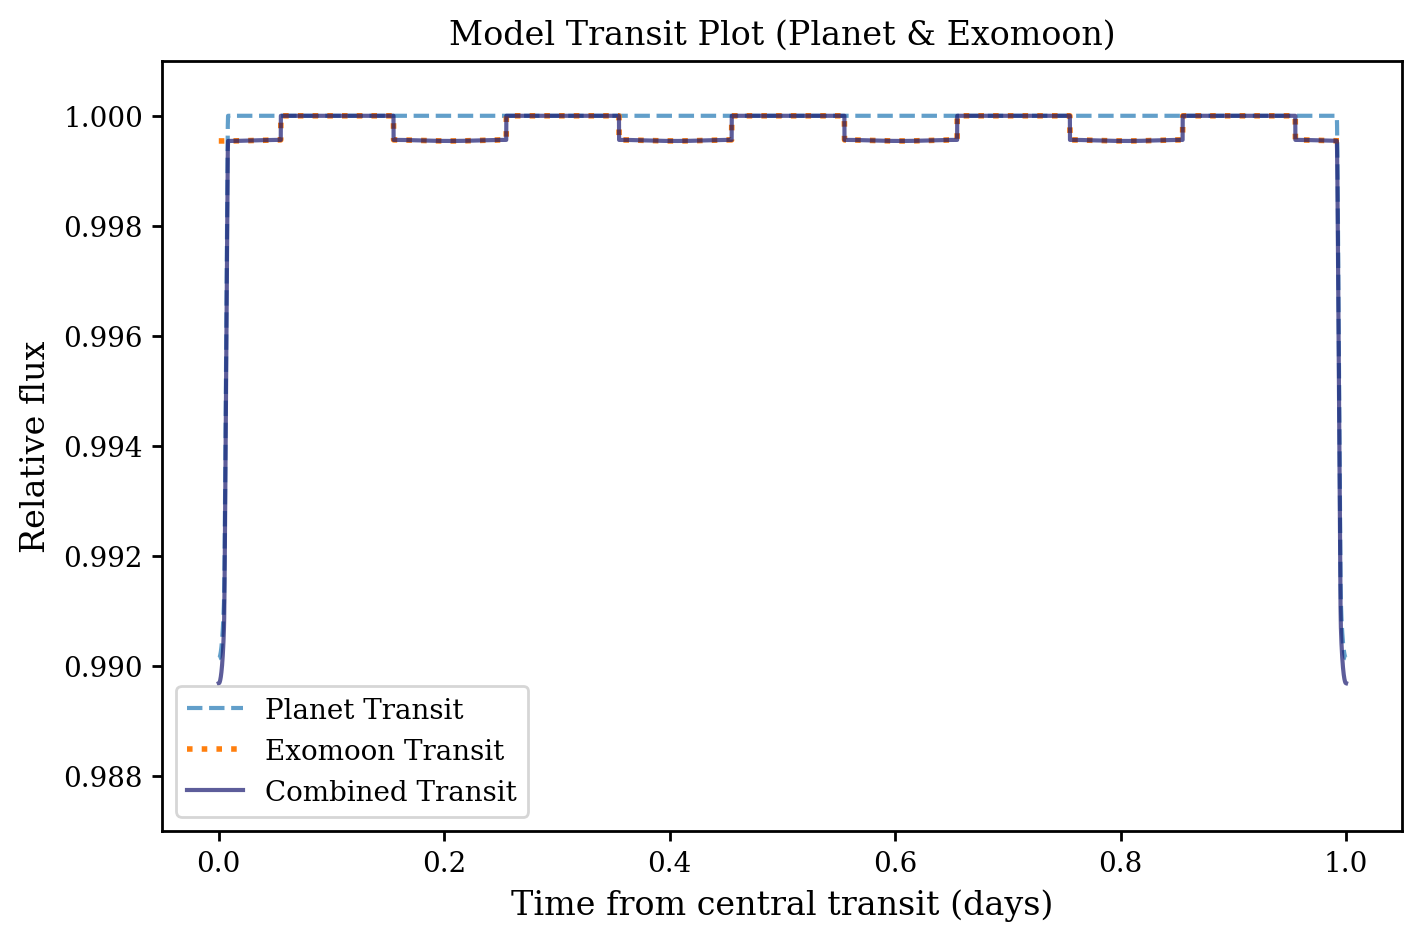

In [81]:
# Test script to make sure that we can create a transit for exomoon purposes. Variable values are taken from the batman code github: 

params = batman.TransitParams()
params.t0 = 0.                        #time of inferior conjunction
params.per = 1.                       #orbital period
params.rp = 0.1                       #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

# Exomoon: 

moon_params = batman.TransitParams()
moon_params.t0 = 0.005                
moon_params.per = 0.2                 
moon_params.rp = 0.02                
moon_params.a = 0.5                   
moon_params.inc = 90.0                
moon_params.ecc = 0.0                
moon_params.w = 90.0                  
moon_params.limb_dark = "nonlinear"   
moon_params.u = [0.5, 0.1, 0.1, -0.1] 

#t = np.linspace(-0.025, 0.025, 1000)  #times at which to calculate light curve
t = np.linspace(0, 1.0, 16779)
m_planet = batman.TransitModel(params, t)    #initializes model
m_moon = batman.TransitModel(moon_params, t)
planet_flux = m_planet.light_curve(params) 
moon_flux = m_moon.light_curve(moon_params)
#radii = np.linspace(0.09, 0.11, 20)
combined_flux = planet_flux * moon_flux # assuming that the transit events happen independently. Is this a reasonable approximation / is this a 
#physical way to calculate this?
#noise_level = 0.0005  # Noise standard deviation (adjust as needed)
#noisy_flux = combined_flux + np.random.normal(0, noise_level, len(combined_flux))
#for r in radii:
    #params.rp = r                           #updates planet radius
    #new_flux = m.light_curve(params)        #recalculates light curve
plt.figure(figsize=(8, 5))
plt.plot(t, planet_flux, label="Planet Transit", linestyle="--", alpha=0.7)
plt.plot(t, moon_flux, label="Exomoon Transit", linestyle=":", linewidth = 2)
plt.plot(t, combined_flux, label="Combined Transit", color="midnightblue", linestyle="-", alpha = 0.7)
plt.title("Model Transit Plot (Planet & Exomoon)")
plt.xlabel("Time from central transit (days)")
plt.ylabel("Relative flux")
plt.ylim((0.987, 1.001))
plt.legend()
plt.show()